In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import opendatasets as od
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

In [3]:
# Download the dataset using opendatasets
dataset_url = 'https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset'
od.download(dataset_url)


Skipping, found downloaded files in "./breast-cancer-dataset" (use force=True to force download)


In [4]:
# Load the dataset
data_dir = 'breast-cancer-dataset'
breast_cancer = os.path.join(data_dir, 'breast-cancer.csv')
df = pd.read_csv(breast_cancer)

In [5]:
# Encode categorical data into numerical
labelencoder_Y = LabelEncoder()
df.iloc[:, 1] = labelencoder_Y.fit_transform(df.iloc[:, 1].values)


In [6]:
# Select features and target variable
X = df[['concave points_mean', 'radius_worst', 'perimeter_worst', 'concave points_worst']].values
Y = df['diagnosis'].values

In [7]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


In [8]:
# Scale the data using StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)
X_test = sc.transform(X_test)

In [14]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load your breast cancer dataset (replace with your data loading code)
# df = pd.read_csv('your_dataset.csv')

# Select features for clustering (e.g., 'concave points_mean', 'radius_worst', 'perimeter_worst')
selected_features = df[['concave points_mean', 'radius_worst', 'perimeter_worst']].values

# Standardize the features
scaler = StandardScaler()
selected_features_std = scaler.fit_transform(selected_features)

# Function to remove outliers using IQR method
def remove_outliers_iqr(data, threshold=1.5):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask]

# Remove outliers
selected_features_std_no_outliers = remove_outliers_iqr(selected_features_std)

# Apply K-Means clustering to the cleaned data
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(selected_features_std_no_outliers)




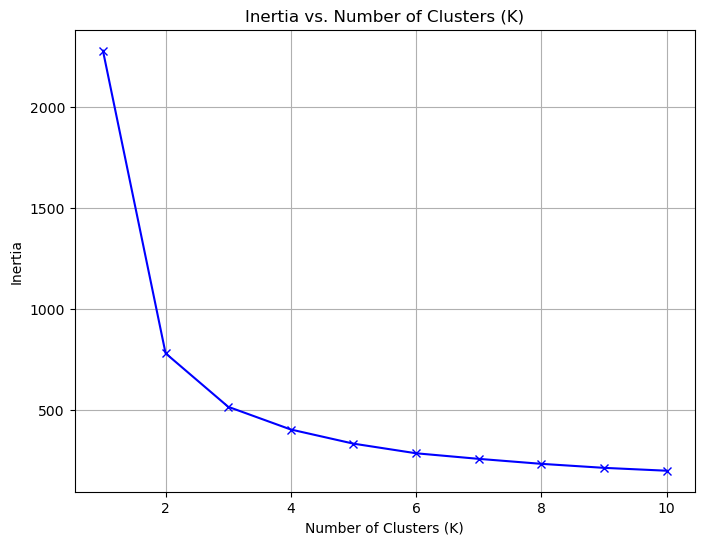

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select features for clustering
selected_features = df[['concave points_mean', 'radius_worst', 'perimeter_worst', 'concave points_worst']].values

# Standardize the features
scaler = StandardScaler()
selected_features_std = scaler.fit_transform(selected_features)

# Create a range of values for k (number of clusters)
k_values = range(1, 11)  # You can adjust the range as needed

# Initialize an empty list to store the inertia values
inertia_values = []

# Calculate inertia for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_features_std)
    inertia = kmeans.inertia_
    inertia_values.append(inertia)

# Plot the inertia graph
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='x', linestyle='-', color='b')
plt.title('Inertia vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


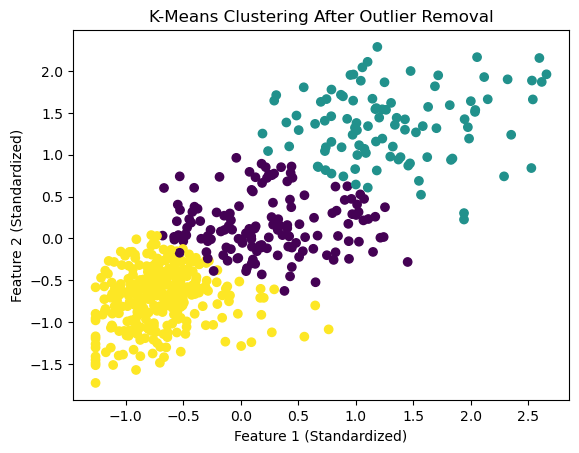

In [15]:
# Visualize the clusters
plt.scatter(selected_features_std_no_outliers[:, 0], selected_features_std_no_outliers[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering After Outlier Removal')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.show()

In [16]:
# Create a majority class baseline model
majority_class_baseline = DummyClassifier(strategy="most_frequent")
majority_class_baseline.fit(X_train, Y_train)
predictions = majority_class_baseline.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)
print(f"Majority Class Baseline Accuracy: {accuracy:.2f}")



Majority Class Baseline Accuracy: 0.70


In [ ]:
# Function to train and evaluate models
def train_and_evaluate_models(X_train, Y_train, X_validation, Y_validation):
    models = []
    
    # Logistic Regression
    log = LogisticRegression(random_state=42)
    log.fit(X_train, Y_train)
    models.append(log)

    # Decision Tree Classifier
    tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
    tree.fit(X_train, Y_train)
    models.append(tree)

    # Random Forest Classifier
    forest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42)
    forest.fit(X_train, Y_train)
    models.append(forest)
    
    # K-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=12)
    knn.fit(X_train, Y_train)
    models.append(knn)

    # XGBoost
    xgb_model = xgb.XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        random_state=42)
    xgb_model.fit(X_train, Y_train)
    models.append(xgb_model)

    # Evaluate models on validation set
    for idx, model in enumerate(models):
        validation_predictions = model.predict(X_validation)
        validation_accuracy = accuracy_score(Y_validation, validation_predictions)
        print(f'Model [{idx}] Validation Accuracy: {validation_accuracy:.2f}')

    return models

In [ ]:
# Train and evaluate models on the validation set
trained_models = train_and_evaluate_models(X_train, Y_train, X_validation, Y_validation)


In [ ]:
# Select the Logistic Regression model for testing
selected_model = trained_models[0]


In [ ]:
# Evaluate the selected model on the test set
test_predictions = selected_model.predict(X_test)
test_accuracy = accuracy_score(Y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")


In [ ]:
# Save predictions to a CSV file
predictions_df = pd.DataFrame({'Predictions': test_predictions, 'True Labels': Y_test})
csv_file_path = 'predictions.csv'
predictions_df.to_csv(csv_file_path, index=False)
print(f'Predictions saved to {csv_file_path}')